# Speech Enhancement Algorithm based on Tensorflow and Keras

**Braude - College of Engineering in Karmiel**

**Capstone Project Phase B –61999**

**24-1-R-11**

The code for this project was developed using Python and the Keras API within TensorFlow, implemented on the Kaggle platform. The datasets used for training and testing include RAVDESS_8K, which provides clean speech data, and UrbanSound8K, containing a variety of environmental noise samples, both dataset samples are in 8 kHz. Data preprocessing involved downsampling the audio files to 8 kHz, if they are different. As well as augmenting the clean speech data with different levels of noise, according to two types of factors, urban_noise_factor and white_noisy_factor, that determine the intensity of the noise that will be added to the clean speech from RAVDESS dataset.


Please cite this notebook if you use it.

Elad Fisher & Avihay Hadad

# Global Variables

In [54]:
batch_size = 16
num_of_filters = 16
num_of_layers = 4
num_of_epochs = 30

# Amount of noise influence
white_noise_factor = 0.07 # 0.03
urban_noise_factor = 0.2 # 0.4

# Validating Params

In [55]:
def check_params(batch_size, num_of_filters, num_of_layers, num_of_epochs, white_noise_factor, urban_noise_factor):
    assert isinstance(batch_size, int) and 0 < batch_size <= 256, "Batch size should be a positive integer (max 256)."
    assert isinstance(num_of_filters, int) and 0 < num_of_filters <= 512, "Number of filters should be a positive integer (max 512)."
    assert isinstance(num_of_layers, int) and 0 < num_of_layers <= 100, "Number of layers should be a positive integer (max 100)."
    assert isinstance(num_of_epochs, int) and 0 < num_of_epochs <= 1000, "Number of epochs should be a positive integer (max 1000)."
    assert isinstance(white_noise_factor, float) and 0 <= white_noise_factor <= 1, "White noise factor should be a float between 0 and 1."
    assert isinstance(urban_noise_factor, float) and 0 <= urban_noise_factor <= 1, "Urban noise factor should be a float between 0 and 1."
    print("All parameters are within the valid ranges!")

check_params(batch_size, num_of_filters, num_of_layers, num_of_epochs, white_noise_factor, urban_noise_factor)

All parameters are within the valid ranges!


# Imports

In [56]:
!pip install pypesq

In [57]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_io as tfio
import keras
from keras.models import Sequential
import tensorflow_io as tfio
import warnings
import glob
from keras.callbacks import ModelCheckpoint
from pypesq import pesq
import soundfile as sf

# Load Data and Preprocess

In [58]:
sr=8000
speech_length_pix_sec=27e-3
total_length = 3.6
trim_length = 28305
n_fft=255
frame_length=255
frame_step = 110

choir_files = glob.glob('/kaggle/input/choir-sounds/*.wav')
noisefiles = glob.glob('/kaggle/input/urban-sound-8k/**/*.wav')
files = glob.glob('/kaggle/input/ravdess-8k/**/*.wav')
print(len(files),'clean data files')
print('Should be similar value to trim length', total_length*sr,trim_length)
print('Should be similar value to n_fft',n_fft, int(speech_length_pix_sec*sr))

@tf.function
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=sr)
    return wav

@tf.function
def preprocess_tf(filepath):
    wav = load_wav(filepath)
    wav = wav[:trim_length]
    zero_padding = tf.zeros([trim_length] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    return wav

@tf.function
def white_noise(data,factor=white_noise_factor):
    noise_amp = factor*tf.reduce_max(data)*tf.random.normal(shape=(1,))
    corr_data = data + noise_amp*tf.random.normal(shape=tf.shape(data))
    return corr_data, data

@tf.function
def urban_noise(corr_data, data, factor=urban_noise_factor,sr=sr):
    noisefile = tf.gather(noisefiles,tf.random.uniform((),0, len(noisefiles)-1,dtype=tf.int32))
    noisefile  = load_wav(noisefile)
    mixed = noisefile * factor * tf.reduce_max(corr_data)/tf.reduce_max(noisefile) + corr_data 
    return mixed, data

@tf.function
def convert_to_spectrogram(wav_corr, wavclean):
    spectrogram_corr = tf.signal.stft(wav_corr, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    spectrogram = tf.signal.stft(wavclean, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    return spectrogram_corr, spectrogram

@tf.function
def spectrogram_abs(spectrogram_corr, spectrogram):
    spectrogram = tf.abs(spectrogram)
    spectrogram_corr = tf.abs(spectrogram_corr)
    return spectrogram_corr, spectrogram

@tf.function
def augment(spectrogram_corr, spectrogram):
    spectrogram_corr = tfio.audio.freq_mask(spectrogram_corr, 10)
    spectrogram_corr = tfio.audio.time_mask(spectrogram_corr, 20)
    return spectrogram_corr, spectrogram

@tf.function
def expand_dims(spectrogram_corr, spectrogram):
    spectrogram_corr = tf.expand_dims(spectrogram_corr, axis=2)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram_corr, spectrogram

1440 clean data files
Should be similar value to trim length 28800.0 28305
Should be similar value to n_fft 255 216


In [59]:
train_val_split_ratio = 0.2
split_index = int(len(files)*train_val_split_ratio)
train_files = files[split_index:]
val_files = files[:split_index]

def configure_dataset(files, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(load_wav, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(white_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(urban_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(convert_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    if not train:
        dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE)

    if train:
        dataset = dataset.map(spectrogram_abs, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE)
        
        dataset = dataset.batch(batch_size)
        dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset
train_dataset = configure_dataset(train_files)
val_dataset = configure_dataset(val_files)

# Create and Run Model

In [60]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    Dropout,
    SpatialDropout2D,
    UpSampling2D,
    Input,
    concatenate,
    multiply,
    add,
    Activation,
)


def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)


def upsample_simple(filters, kernel_size, strides, padding):
    return UpSampling2D(strides)


def attention_gate(inp_1, inp_2, n_intermediate_filters):
    """Attention gate. Compresses both inputs to n_intermediate_filters filters before processing.
       Implemented as proposed by Oktay et al. in their Attention U-net, see: https://arxiv.org/abs/1804.03999.
    """
    inp_1_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_1)
    inp_2_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_2)

    f = Activation("relu")(add([inp_1_conv, inp_2_conv]))
    g = Conv2D(
        filters=1,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(f)
    h = Activation("sigmoid")(g)
    return multiply([inp_1, h])


def attention_concat(conv_below, skip_connection):
    """Performs concatenation of upsampled conv_below with attention gated version of skip-connection
    """
    below_filters = conv_below.get_shape().as_list()[-1]
    attention_across = attention_gate(skip_connection, conv_below, below_filters)
    return concatenate([conv_below, attention_across])


def conv2d_block(
    inputs,
    use_batch_norm=True,
    dropout=0.3,
    dropout_type="spatial",
    filters=16,
    kernel_size=(3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
):

    if dropout_type == "spatial":
        DO = SpatialDropout2D
    elif dropout_type == "standard":
        DO = Dropout
    else:
        raise ValueError(
            f"dropout_type must be one of ['spatial', 'standard'], got {dropout_type}"
        )

    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(inputs)
    if use_batch_norm:
        c = BatchNormalization()(c)
    if dropout > 0.0:
        c = DO(dropout)(c)
    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(c)
    if use_batch_norm:
        c = BatchNormalization()(c)
    return c


def custom_unet(
    input_shape,
    num_classes=1,
    activation="relu",
    use_batch_norm=True,
    upsample_mode="deconv",  # 'deconv' or 'simple'
    dropout=0.3,
    dropout_change_per_layer=0.0,
    dropout_type="spatial",
    use_dropout_on_upsampling=False,
    use_attention=False,
    filters=16,
    num_layers=4,
    output_activation="sigmoid",
):  # 'sigmoid' or 'softmax'

    if upsample_mode == "deconv":
        upsample = upsample_conv
    else:
        upsample = upsample_simple

    # Build U-Net model
    inputs = Input(input_shape)
    inputs_copy = tf.identity(inputs)
    x = inputs / tf.reduce_max(inputs)

    down_layers = []
    for l in range(num_layers):
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )
        down_layers.append(x)
        x = MaxPooling2D((2, 2))(x)
        dropout += dropout_change_per_layer
        filters = filters * 2  # double the number of filters with each layer

    x = conv2d_block(
        inputs=x,
        filters=filters,
        use_batch_norm=use_batch_norm,
        dropout=dropout,
        dropout_type=dropout_type,
        activation=activation,
    )

    if not use_dropout_on_upsampling:
        dropout = 0.0
        dropout_change_per_layer = 0.0

    for conv in reversed(down_layers):
        filters //= 2  # decreasing number of filters with each layer
        dropout -= dropout_change_per_layer
        x = upsample(filters, (2, 2), strides=(2, 2), padding="same")(x)
        if use_attention:
            x = attention_concat(conv_below=x, skip_connection=conv)
        else:
            x = concatenate([x, conv])
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )

    output_mask = Conv2D(num_classes, (1, 1), activation=output_activation)(x)
    outputs = keras.layers.Multiply()([output_mask, inputs_copy])
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


model_filename = **model_weights_batchSize_numOfFilter_numOfLayers.h5**

In [61]:
model = custom_unet(
    input_shape=(256, 128, 1),
    use_batch_norm=True,
    num_classes=1,
    filters=num_of_filters, 
    num_layers=num_of_layers,
    dropout=0.2,
    output_activation='sigmoid')

model_filename = f'model_weights_{batch_size}_{num_of_filters}_{num_of_layers}_{num_of_epochs}_{white_noise_factor}_{urban_noise_factor}.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss',
    save_weights_only=True,
    save_best_only=True)

callback_early_stop =tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    mode="auto",
    restore_best_weights=True,
)

def signal_enhancement_loss(y_true, y_pred):
    mae = tf.abs(y_true - y_pred)
    speech_loss =  2 * tf.abs(y_true**2 - y_pred*y_true)
    return tf.reduce_mean(mae, axis=-1) + tf.reduce_mean(speech_loss, axis=-1) # Note the `axis=-1`

model.compile(optimizer='adam', loss=signal_enhancement_loss)

In [62]:
# For manually checking the model has valid params (as configured in the global params)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 128, 1) 0                                            
__________________________________________________________________________________________________
tf.math.reduce_max_5 (TFOpLambd ()                   0           input_6[0][0]                    
__________________________________________________________________________________________________
tf.math.truediv_5 (TFOpLambda)  (None, 256, 128, 1)  0           input_6[0][0]                    
                                                                 tf.math.reduce_max_5[0][0]       
__________________________________________________________________________________________________
conv2d_103 (Conv2D)             (None, 256, 128, 16) 144         tf.math.truediv_5[0][0]    

**For loading saved weights**

In [63]:
model.load_weights(f'/kaggle/input/speech-model-weights/{model_filename}')
history = None

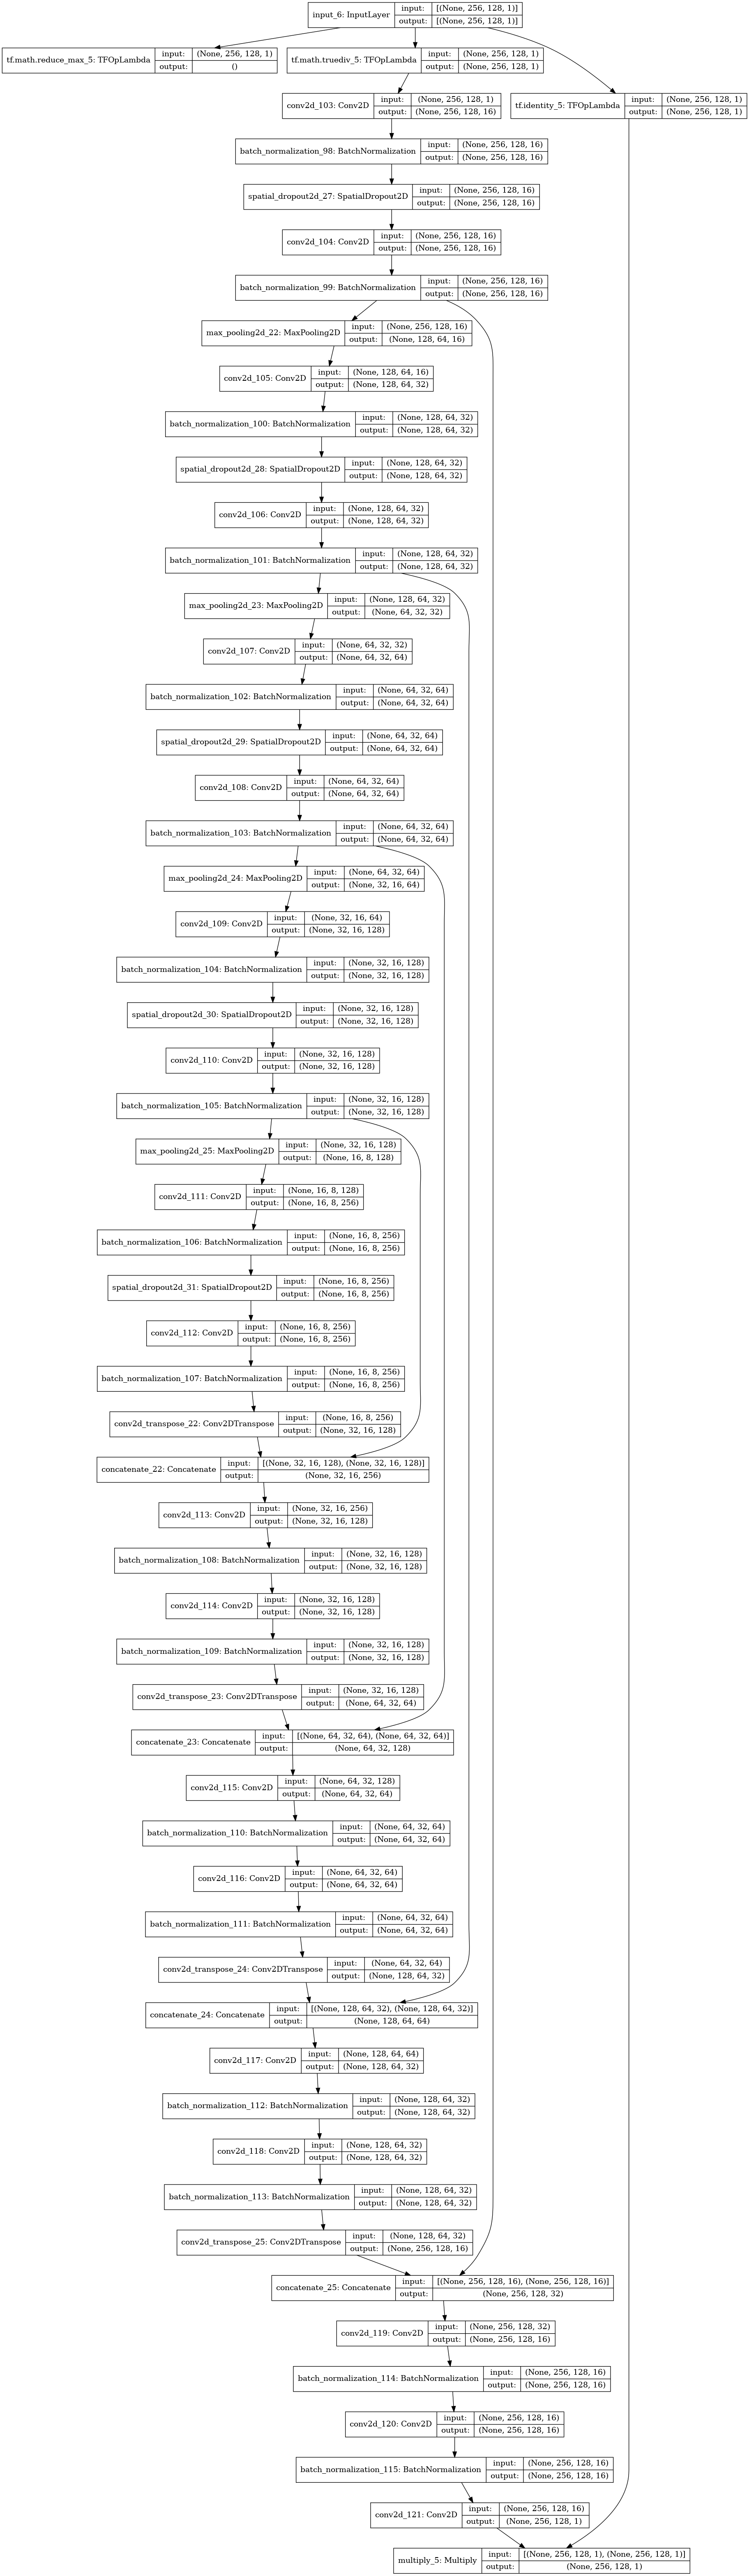

In [64]:
keras.utils.vis_utils.plot_model(model,show_shapes=True)

# Run Model - Training

In [65]:
# history = model.fit(train_dataset, epochs=num_of_epochs, shuffle=True, validation_data=val_dataset,
#                     callbacks=[callback_checkpoint, callback_early_stop])

In [66]:
results_dir = f'val_results_{batch_size}_{num_of_filters}_{num_of_layers}_{num_of_epochs}_{white_noise_factor}_{urban_noise_factor}'

In [67]:
os.system(f'rm -r {results_dir}')

0

In [68]:
os.mkdir(results_dir)

# Inspect Multiple Speakers / Choir Results

In [69]:
trim_length = 28305
files_to_test = choir_files
test_dataset = configure_dataset(files_to_test,train=False)
num = test_dataset.as_numpy_iterator()
mae = tf.keras.losses.MeanAbsoluteError()
pesq_with_noise = np.zeros(len(files_to_test))
pesq_denoised = np.zeros(len(files_to_test))

wav_clean_array =  np.zeros((len(files_to_test),trim_length))
wav_corrupt_array =  np.zeros((len(files_to_test),trim_length))
wav_correct_array =  np.zeros((len(files_to_test),trim_length))
spec_clean_array=  np.zeros((len(files_to_test), 256, 128))
spec_corrupt_array=  np.zeros((len(files_to_test), 256, 128))
spec_correct_array=  np.zeros((len(files_to_test), 256, 128))
loss_with_noise = np.zeros(len(files_to_test))
loss_denoised = np.zeros(len(files_to_test))


for ind in range(len(files_to_test)):
    corr, clean = num.next()
    corr_wav = tf.signal.inverse_stft(corr[:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    clean_wav = tf.signal.inverse_stft(clean[:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    corr_amp = np.abs(corr)
    corrected_amp = model.predict(np.expand_dims(corr_amp,0))
    corrected_spec = corrected_amp * np.exp(1j*np.angle(np.expand_dims(corr,0)))
    corrected_wav = tf.signal.inverse_stft(corrected_spec[0,:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step) 
     
    pesq_with_noise[ind] = pesq(clean_wav,corr_wav,sr)
    pesq_denoised[ind] = pesq(clean_wav,corrected_wav,sr)
    wav_clean_array[ind] = clean_wav
    wav_corrupt_array[ind] = corr_wav
    wav_correct_array[ind] = corrected_wav
    spec_clean_array[ind] = np.abs(clean[:,:,0])
    spec_corrupt_array[ind] = np.abs(corr[:,:,0])
    spec_correct_array[ind] = corrected_amp[0,:,:,0]
    loss_with_noise[ind] = tf.reduce_mean(signal_enhancement_loss(np.abs(clean), corr_amp)).numpy()
    loss_denoised[ind] =tf.reduce_mean(signal_enhancement_loss(np.abs(clean[:,:,0]), corrected_amp[0,:,:,0])).numpy()

pesq_diff = pesq_denoised - pesq_with_noise

print(np.mean(pesq_with_noise), np.mean(pesq_denoised), pesq_diff.mean())

f'{np.mean(pesq_with_noise):.2f}, {np.mean(pesq_denoised):.2f}'

2.379910469055176 2.3988029956817627 0.018892526626586914


'2.38, 2.40'

**Showing all audio of Choir / Multiple speakers**

In [70]:
#Showing all audio
for ind in range(len(wav_clean_array)):
    curr_filename = choir_files[ind].split("/")[-1]
    print(f"{curr_filename}: Clean -> Noisy -> Enhanced")
    display(Audio(wav_clean_array[ind],rate=sr))
    display(Audio(wav_corrupt_array[ind],rate=sr))
    display(Audio(wav_correct_array[ind],rate=sr))

ind=np.where(pesq_diff==pesq_diff.max())[0][0]
curr_filename = choir_files[ind].split("/")[-1]
print(f"{curr_filename}: Best Improved")
display(Audio(wav_clean_array[ind],rate=sr))
display(Audio(wav_corrupt_array[ind],rate=sr))
display(Audio(wav_correct_array[ind],rate=sr))

ind=np.argmin(np.abs(pesq_diff - np.mean(pesq_diff)))
curr_filename = choir_files[ind].split("/")[-1]
print(f"{curr_filename}: Avg Improved")
display(Audio(wav_clean_array[ind],rate=sr))
display(Audio(wav_corrupt_array[ind],rate=sr))
display(Audio(wav_correct_array[ind],rate=sr))

ind=np.where(pesq_diff==pesq_diff.min())[0][0]
curr_filename = choir_files[ind].split("/")[-1]
print(f"{curr_filename}: Worst Improved")
display(Audio(wav_clean_array[ind],rate=sr))
display(Audio(wav_corrupt_array[ind],rate=sr))
display(Audio(wav_correct_array[ind],rate=sr))

choir1.wav: Clean -> Noisy -> Enhanced


BBC_second.wav: Clean -> Noisy -> Enhanced


BBC_second_cont.wav: Clean -> Noisy -> Enhanced


BBC_first.wav: Clean -> Noisy -> Enhanced


BBC_first_cont.wav: Clean -> Noisy -> Enhanced


Dual_Speakers.wav: Clean -> Noisy -> Enhanced


BBC_second.wav: Best Improved


BBC_second_cont.wav: Avg Improved


choir1.wav: Worst Improved


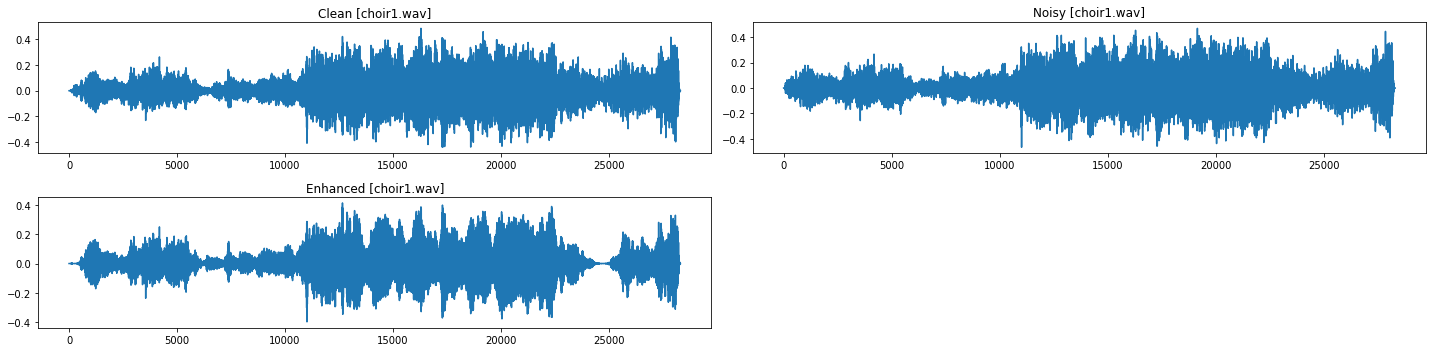

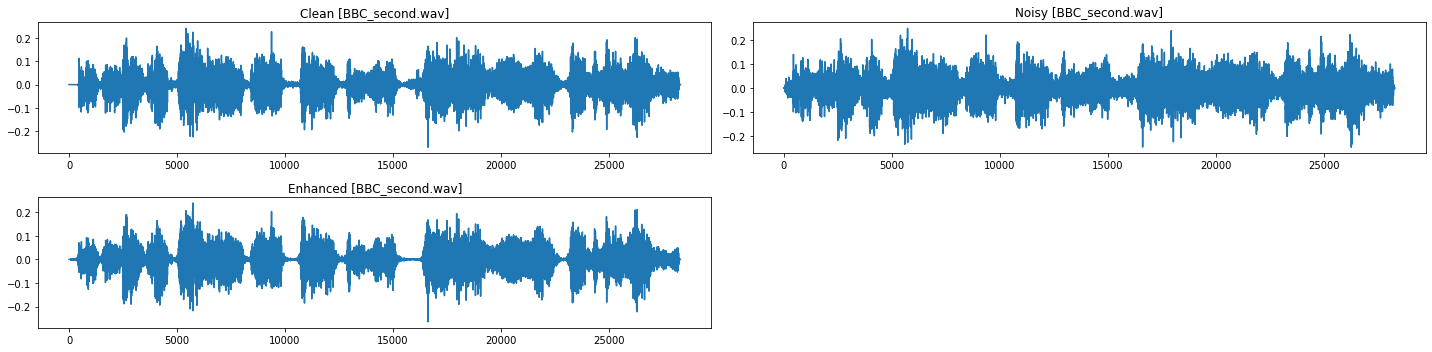

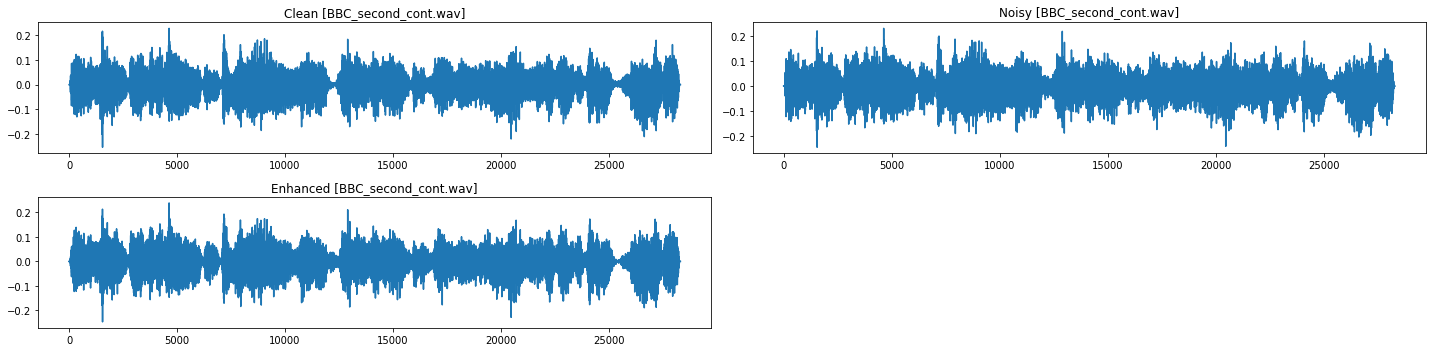

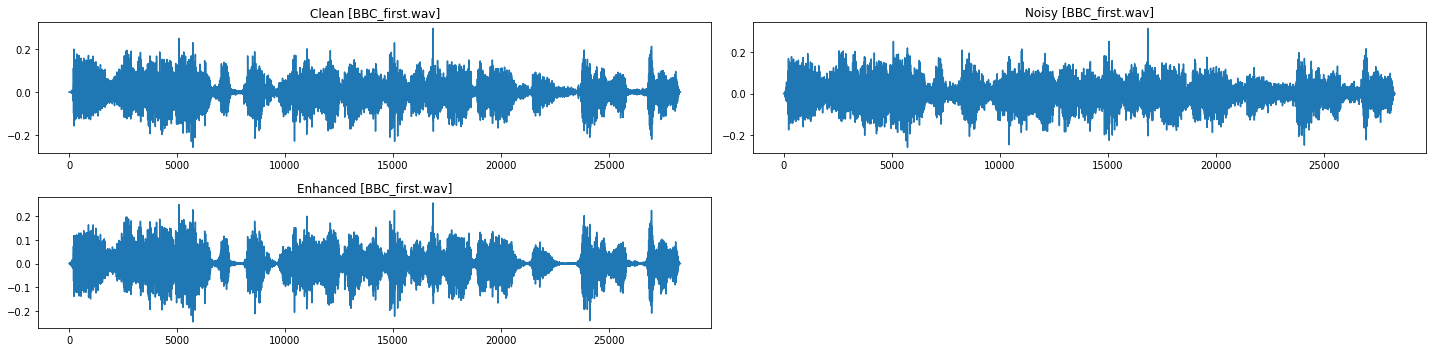

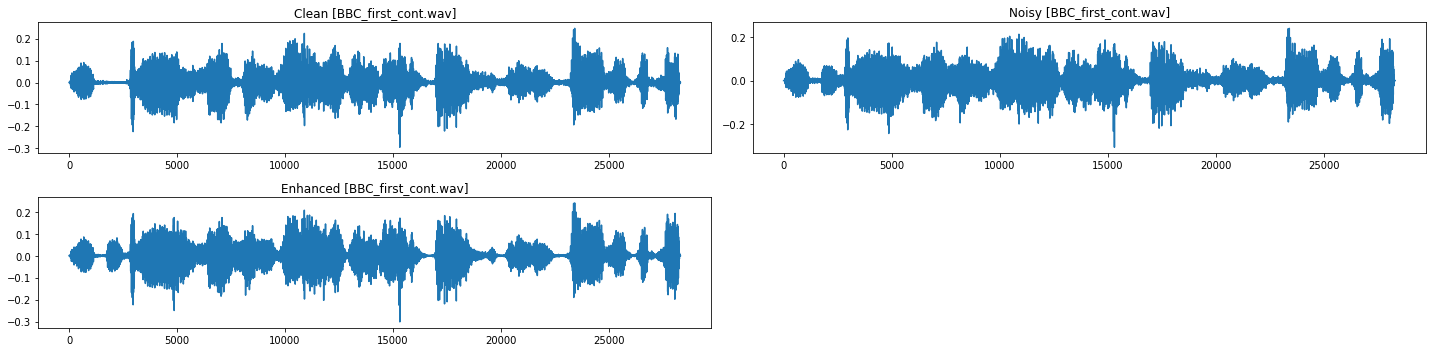

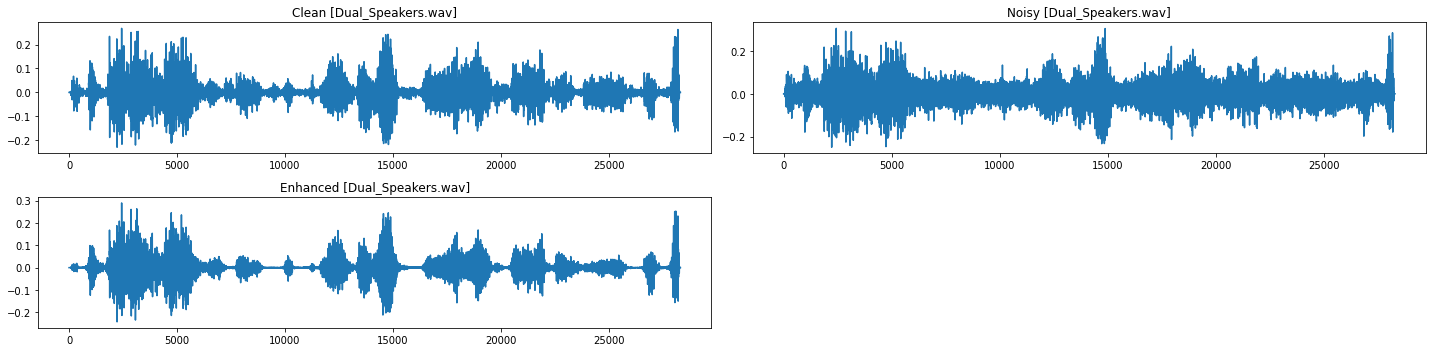

In [71]:
def plot_waveforms(clean, noisy, enhanced, index):
    title = choir_files[index].split("/")[-1]
    plt.figure(figsize=(20, 5))
    plt.subplot(2, 2, 1)
    plt.plot(clean)
    plt.title(f'Clean [{title}]')
    plt.subplot(2, 2, 2)
    plt.plot(noisy)
    plt.title(f'Noisy [{title}]')
    plt.subplot(2, 2, 3)
    plt.plot(enhanced)
    plt.title(f'Enhanced [{title}]')
    plt.tight_layout()
    plt.savefig(f'{results_dir}/{title}_waveforms.png')

# Plot all chior waveplot
for ind in range(len(wav_clean_array)):
    plot_waveforms(wav_clean_array[ind], wav_corrupt_array[ind], wav_correct_array[ind], ind)

In [72]:
print(f"PESQ noisy: {np.mean(pesq_with_noise):.4f}, PESQ denoised: {np.mean(pesq_denoised):.4f}, PESQ diff: {pesq_diff.mean():.4f}")

PESQ noisy: 2.3799, PESQ denoised: 2.3988, PESQ diff: 0.0189


# Inspect Results

In [73]:
trim_length = 28305
files_to_test = val_files
test_dataset = configure_dataset(files_to_test,train=False)
num = test_dataset.as_numpy_iterator()
mae = tf.keras.losses.MeanAbsoluteError()
pesq_with_noise = np.zeros(len(files_to_test))
pesq_denoised = np.zeros(len(files_to_test))

wav_clean_array =  np.zeros((len(files_to_test),trim_length))
wav_corrupt_array =  np.zeros((len(files_to_test),trim_length))
wav_correct_array =  np.zeros((len(files_to_test),trim_length))
spec_clean_array=  np.zeros((len(files_to_test), 256, 128))
spec_corrupt_array=  np.zeros((len(files_to_test), 256, 128))
spec_correct_array=  np.zeros((len(files_to_test), 256, 128))
loss_with_noise = np.zeros(len(files_to_test))
loss_denoised = np.zeros(len(files_to_test))


for ind in range(len(files_to_test)):
    corr, clean = num.next()
    corr_wav = tf.signal.inverse_stft(corr[:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    clean_wav = tf.signal.inverse_stft(clean[:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    corr_amp = np.abs(corr)
    corrected_amp = model.predict(np.expand_dims(corr_amp,0))
    corrected_spec = corrected_amp * np.exp(1j*np.angle(np.expand_dims(corr,0)))
    corrected_wav = tf.signal.inverse_stft(corrected_spec[0,:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step) 
     
    pesq_with_noise[ind] = pesq(clean_wav,corr_wav,sr)
    pesq_denoised[ind] = pesq(clean_wav,corrected_wav,sr)
    wav_clean_array[ind] = clean_wav
    wav_corrupt_array[ind] = corr_wav
    wav_correct_array[ind] = corrected_wav
    spec_clean_array[ind] = np.abs(clean[:,:,0])
    spec_corrupt_array[ind] = np.abs(corr[:,:,0])
    spec_correct_array[ind] = corrected_amp[0,:,:,0]
    loss_with_noise[ind] = tf.reduce_mean(signal_enhancement_loss(np.abs(clean), corr_amp)).numpy()
    loss_denoised[ind] =tf.reduce_mean(signal_enhancement_loss(np.abs(clean[:,:,0]), corrected_amp[0,:,:,0])).numpy()

pesq_diff = pesq_denoised - pesq_with_noise

print(f"Average Results\nPESQ noisy: {np.mean(pesq_with_noise):.4f}, PESQ denoised: {np.mean(pesq_denoised):.4f}, PESQ diff: {pesq_diff.mean():.4f}")

print(f"Average PESQ: {np.mean(pesq_denoised):.4f}")
print(f"Max PESQ: {np.max(pesq_denoised):.4f}")
print(f"Min PESQ: {np.min(pesq_denoised):.4f}")

Average Results
PESQ noisy: 2.0718, PESQ denoised: 2.6893, PESQ diff: 0.6175
Average PESQ: 2.6893
Max PESQ: 3.6753
Min PESQ: 1.0984


# Loss vs Epoch Graph

In [74]:
if history:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{results_dir}/loss_vs_epoch.png')

# PESQ Improvement Distribution

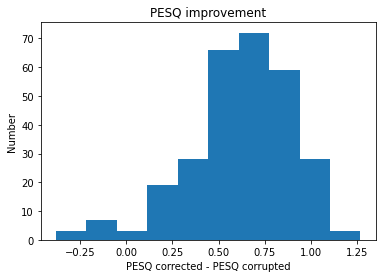

In [75]:
fig = plt.figure()
plt.title('PESQ improvement')
plt.hist(pesq_diff);
plt.xlabel('PESQ corrected - PESQ corrupted')
plt.ylabel('Number')
fig.savefig(results_dir+'/pesq_hist', bbox_inches='tight')

# Average PESQ Scores

In [76]:
print(f"Average PESQ (Noisy): {np.mean(pesq_with_noise):.4f}")
print(f"Average PESQ (Enhanced): {np.mean(pesq_denoised):.4f}")
print(f"Average PESQ Improvement: {np.mean(pesq_diff):.4f}")

Average PESQ (Noisy): 2.0718
Average PESQ (Enhanced): 2.6893
Average PESQ Improvement: 0.6175


# Signal-to-Noise Ratio (SNR) Improvement

Average SNR Improvement: 5.79 dB


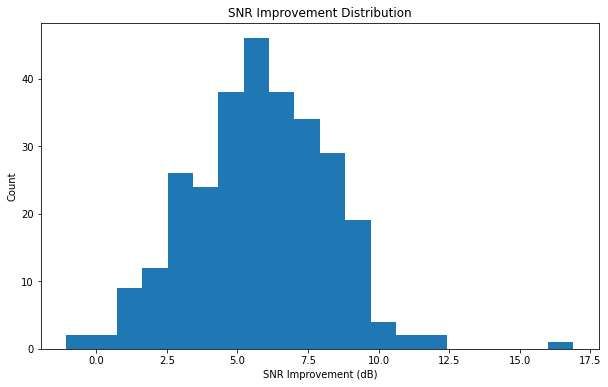

In [77]:
def calculate_snr(clean, noisy):
    noise = clean - noisy
    return 10 * np.log10(np.sum(clean**2) / np.sum(noise**2))

snr_before = np.array([calculate_snr(wav_clean_array[i], wav_corrupt_array[i]) for i in range(len(wav_clean_array))])
snr_after = np.array([calculate_snr(wav_clean_array[i], wav_correct_array[i]) for i in range(len(wav_clean_array))])
snr_improvement = snr_after - snr_before

print(f"Average SNR Improvement: {np.mean(snr_improvement):.2f} dB")

plt.figure(figsize=(10, 6))
plt.hist(snr_improvement, bins=20)
plt.title('SNR Improvement Distribution')
plt.xlabel('SNR Improvement (dB)')
plt.ylabel('Count')
plt.savefig(f'{results_dir}/snr_improvement_hist.png')

In [78]:
ind=np.where(pesq_diff==pesq_diff.max())[0][0]
sf.write(results_dir +'/'+'clean_best_pesq_improvement.wav',wav_clean_array[ind],sr)
sf.write(results_dir +'/'+'corrupt_best_pesq_improvement.wav',wav_corrupt_array[ind],sr)
sf.write(results_dir +'/'+'correct_best_pesq_improvement.wav',wav_correct_array[ind],sr)
print("best_pesq_improvement: Clean -> Noisy -> Enhanced")
display(Audio(wav_clean_array[ind],rate=sr))
display(Audio(wav_corrupt_array[ind],rate=sr))
display(Audio(wav_correct_array[ind],rate=sr))

best_pesq_improvement: Clean -> Noisy -> Enhanced


In [79]:
ind=np.argmin(np.abs(pesq_diff - np.mean(pesq_diff)))
sf.write(results_dir +'/'+'clean_avg_pesq_improvement.wav',wav_clean_array[ind],sr)
sf.write(results_dir +'/'+'corrupt_avg_pesq_improvement.wav',wav_corrupt_array[ind],sr)
sf.write(results_dir +'/'+'correct_avg_pesq_improvement.wav',wav_correct_array[ind],sr)
print("avg_pesq_improvement: Clean -> Noisy -> Enhanced")
display(Audio(wav_clean_array[ind],rate=sr))
display(Audio(wav_corrupt_array[ind],rate=sr))
display(Audio(wav_correct_array[ind],rate=sr))

avg_pesq_improvement: Clean -> Noisy -> Enhanced


In [80]:
ind=np.where(pesq_diff==pesq_diff.min())[0][0]
sf.write(results_dir +'/'+'clean_worst_pesq_improvement.wav',wav_clean_array[ind],sr)
sf.write(results_dir +'/'+'corrupt_worst_pesq_improvement.wav',wav_corrupt_array[ind],sr)
sf.write(results_dir +'/'+'correct_worst_pesq_improvement.wav',wav_correct_array[ind],sr)
print("worst_pesq_improvement: Clean -> Noisy -> Enhanced")
display(Audio(wav_clean_array[ind],rate=sr))
display(Audio(wav_corrupt_array[ind],rate=sr))
display(Audio(wav_correct_array[ind],rate=sr))

worst_pesq_improvement: Clean -> Noisy -> Enhanced


# Spectrogram Comparison

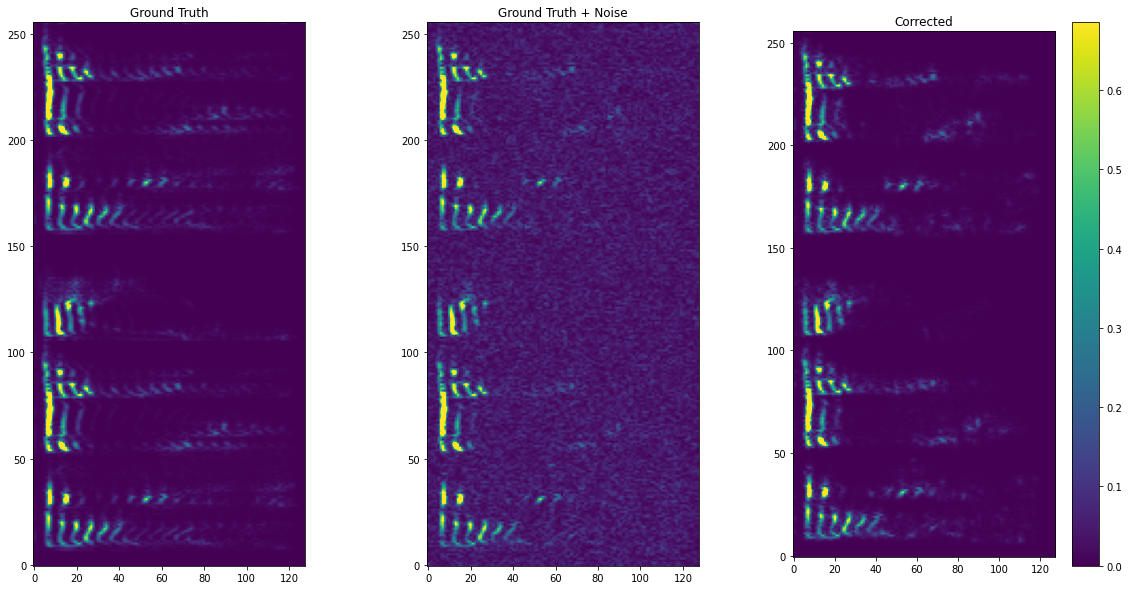

In [81]:
ind=np.where(pesq_diff==pesq_diff.max())[0][0]
fig,axes = plt.subplots(ncols=3,figsize=(20,10))
vmax=spec_clean_array[ind].max()/3
vmin=0
plt.subplot(1,3,1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.colorbar()
fig.savefig(results_dir+'/best_spec.png', bbox_inches='tight')

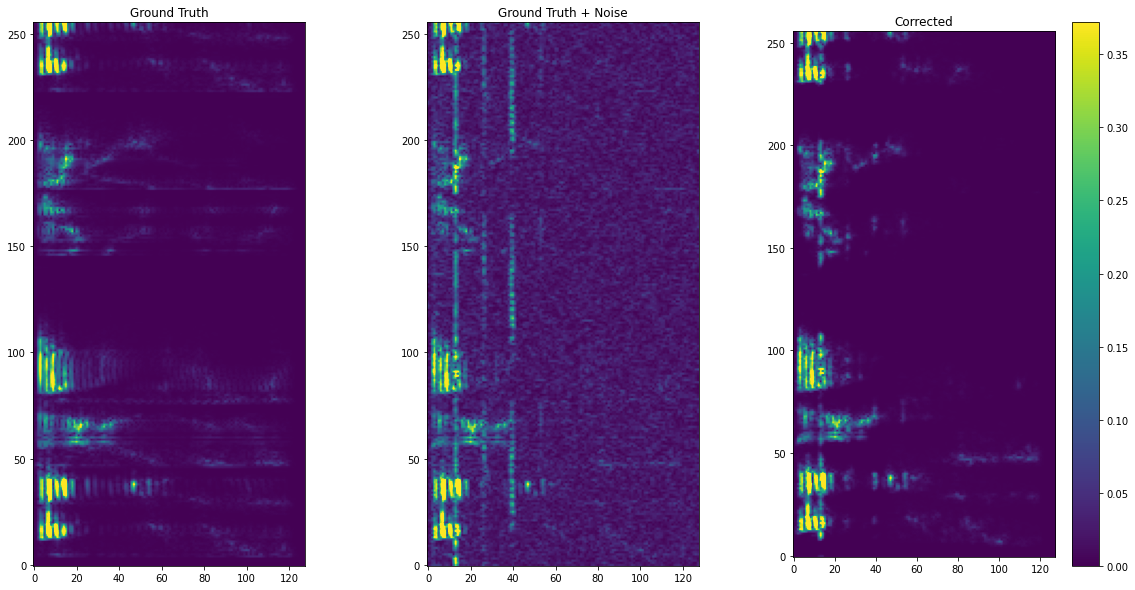

In [82]:
ind=np.where(pesq_diff==pesq_diff.min())[0][0]
fig,axes = plt.subplots(ncols=3,figsize=(20,10))
vmax=spec_clean_array[ind].max()/3
vmin=0
plt.subplot(1,3,1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.colorbar()
fig.savefig(results_dir+'/worst_spec.png', bbox_inches='tight')

# Time-domain Waveform Comparison

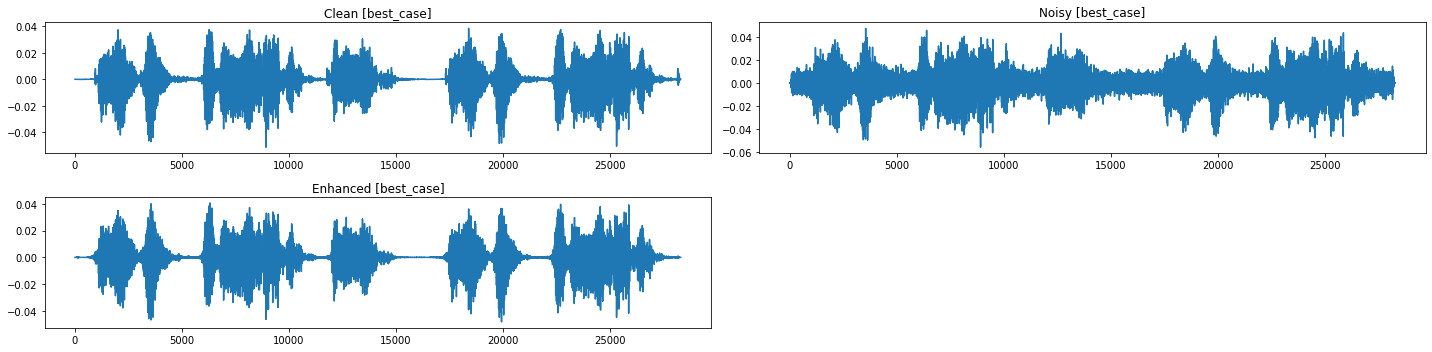

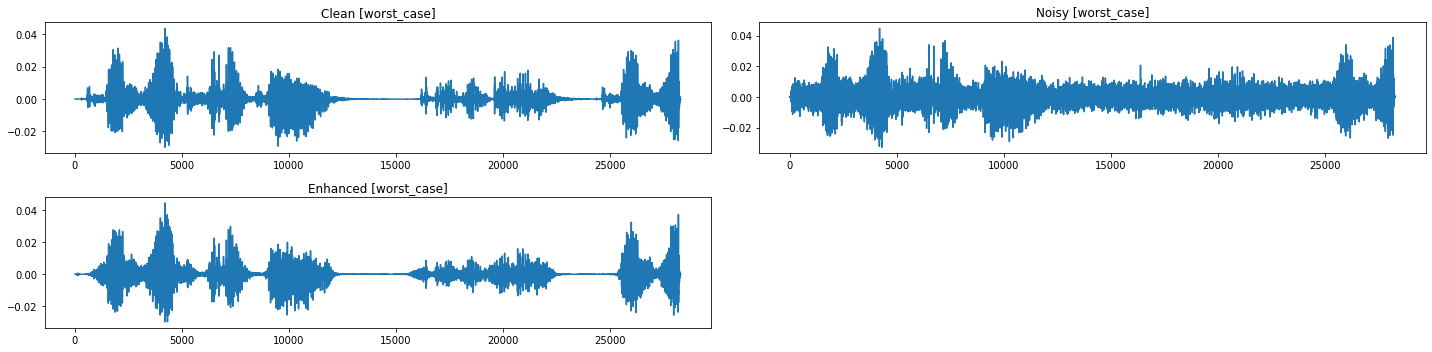

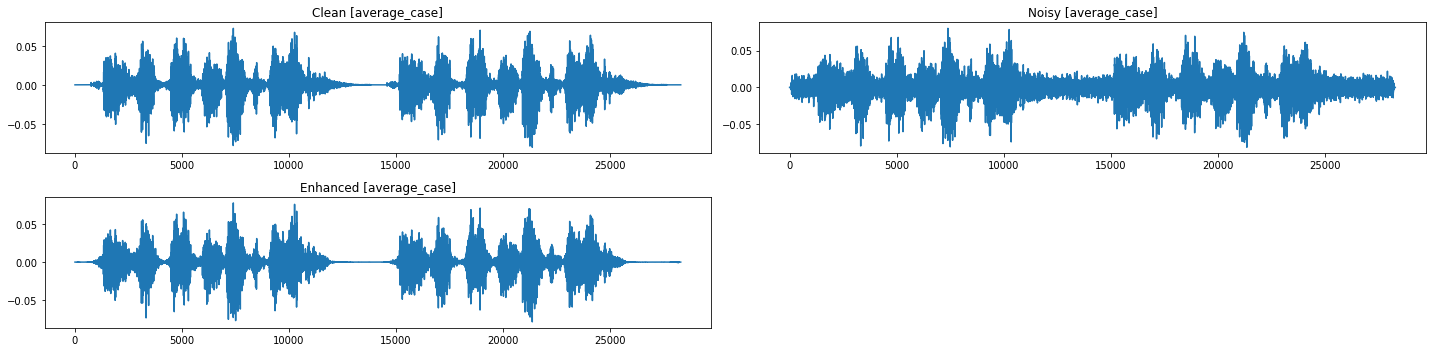

In [83]:
def plot_waveforms(clean, noisy, enhanced, index, title):
    plt.figure(figsize=(20, 5))
    plt.subplot(2, 2, 1)
    plt.plot(clean)
    plt.title(f'Clean [{title}]')
    plt.subplot(2, 2, 2)
    plt.plot(noisy)
    plt.title(f'Noisy [{title}]')
    plt.subplot(2, 2, 3)
    plt.plot(enhanced)
    plt.title(f'Enhanced [{title}]')
    plt.tight_layout()
    plt.savefig(f'{results_dir}/{title}_waveforms.png')

# Plot for best, worst, and average cases
best_index = np.argmax(pesq_diff)
worst_index = np.argmin(pesq_diff)
avg_index = np.argsort(pesq_diff)[len(pesq_diff)//2]

plot_waveforms(wav_clean_array[best_index], wav_corrupt_array[best_index], wav_correct_array[best_index], best_index, 'best_case')
plot_waveforms(wav_clean_array[worst_index], wav_corrupt_array[worst_index], wav_correct_array[worst_index], worst_index, 'worst_case')
plot_waveforms(wav_clean_array[avg_index], wav_corrupt_array[avg_index], wav_correct_array[avg_index], avg_index, 'average_case')

# Noiseless Audio

In [84]:
def multiple_denoise(model, noisy_specs):
    results = []
    for noisy_spec in noisy_specs:
        denoised_spec = model.predict(np.expand_dims(noisy_spec, 0))[0]
        results.append(denoised_spec)
    return results

# Choosing randomly a sample to work with
sample_indexes = [np.random.randint(0, len(spec_clean_array)) for _ in range(5)]
noisy_specs = [spec_clean_array[sample_index] for sample_index in sample_indexes]
clean_samples = [wav_clean_array[sample_index] for sample_index in sample_indexes]

# Perform multiple denoising
denoised_results = multiple_denoise(model, noisy_specs)

# Convert spectrograms back to audio
def spec_to_audio(spec):
    complex_spec = spec * np.exp(1j * np.angle(np.expand_dims(corr, 0)))
    return tf.signal.inverse_stft(complex_spec[0,:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step).numpy()

audio_results = [spec_to_audio(spec) for spec in denoised_results]

# Calculate PESQ for each iteration
pesq_scores = np.array([pesq(clean_samples[ind], clean_samples[ind], sr) for ind in range(len(audio_results))])
pesq_denoised = np.array([pesq(clean_samples[ind], audio_results[ind], sr) for ind in range(len(audio_results))])
pesq_diff = pesq_denoised - pesq_scores
print(f"PESQ noisy: {np.mean(pesq_scores)}, PESQ denoised: {np.mean(pesq_denoised)}, PESQ diff: {pesq_diff.mean()}")

# Calculate statistics
print(f"Average PESQ: {np.mean(pesq_denoised):.4f}")
print(f"Max PESQ: {np.max(pesq_denoised):.4f}")
print(f"Min PESQ: {np.min(pesq_denoised):.4f}")

# Display audio players
for ind in range(len(audio_results)):
    print(f'{ind}. Clean -> "Enhanced"')
    display(Audio(clean_samples[ind], rate=sr))
    display(Audio(audio_results[ind], rate=sr))

PESQ noisy: 4.5, PESQ denoised: 2.830857038497925, PESQ diff: -1.6691429615020752
Average PESQ: 2.8309
Max PESQ: 3.0545
Min PESQ: 2.7147
0. Clean -> "Enhanced"


1. Clean -> "Enhanced"


2. Clean -> "Enhanced"


3. Clean -> "Enhanced"


4. Clean -> "Enhanced"


# Cascading

In [85]:
def get_pretrained_model(batch_size, num_of_filters, num_of_layers, num_of_epochs, white_noise_factor, urban_noise_factor):
    check_params(batch_size, num_of_filters, num_of_layers, num_of_epochs, white_noise_factor, urban_noise_factor)
    unet_model = custom_unet(
    input_shape=(256, 128, 1),
    use_batch_norm=True,
    num_classes=1,
    filters=num_of_filters, 
    num_layers=num_of_layers,
    dropout=0.2,
    output_activation='sigmoid')

    filename = f'model_weights_{batch_size}_{num_of_filters}_{num_of_layers}_{num_of_epochs}_{white_noise_factor}_{urban_noise_factor}.h5'
    callback_checkpoint = ModelCheckpoint(
        filename, 
        verbose=1, 
        monitor='val_loss',
        save_weights_only=True,
        save_best_only=True)

    callback_early_stop =tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=4,
        mode="auto",
        restore_best_weights=True,
    )

    unet_model.compile(optimizer='adam', loss=signal_enhancement_loss)
    unet_model.load_weights(f'/kaggle/input/speech-model-weights/{filename}')
    return unet_model, filename

model_2, model_filename_2 = get_pretrained_model(16, 16, 4, 30, 0.4, 0.4)
model_3, model_filename_3 = get_pretrained_model(16, 32, 4, 30, 0.2, 0.4)
model_4, model_filename_4 = get_pretrained_model(32, 32, 6, 10, 0.1, 0.5)

All parameters are within the valid ranges!
All parameters are within the valid ranges!
All parameters are within the valid ranges!


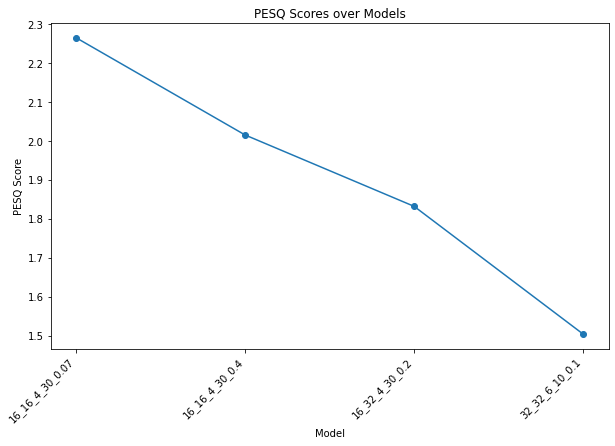

In [86]:
def cascading_denoise(models, noisy_spec):
    results = []
    current_spec = noisy_spec
    for model in models:
        denoised_spec = model.predict(np.expand_dims(current_spec, 0))[0]
        results.append(denoised_spec)
        current_spec = denoised_spec
    return results

# Choose a sample to work with
sample_index = np.random.randint(0, len(spec_corrupt_array))
noisy_sample = spec_corrupt_array[sample_index]
clean_sample = wav_clean_array[sample_index]  # Use the clean waveform

models = [model, model_2, model_3, model_4]
filenames = [model_filename, model_filename_2, model_filename_3, model_filename_4]
# Create shorter versions of the filenames
short_filenames = [
    "_".join(filename.split('_')[2:-1])
    for filename in filenames
]

# All models should be different
def has_duplicates(lst):
    return len(lst) != len(set(lst))
assert not has_duplicates(filenames), "Chosen models for cascading_denoise should be different from each other."

denoised_results = cascading_denoise(models, noisy_sample)

# Convert spectrograms back to audio
def spec_to_audio(spec):
    complex_spec = spec * np.exp(1j * np.angle(np.expand_dims(corr, 0)))
    return tf.signal.inverse_stft(complex_spec[0,:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step).numpy()

audio_results = [spec_to_audio(spec) for spec in denoised_results]

# Calculate PESQ for each iteration
pesq_scores = [pesq(clean_sample, denoised, sr) for denoised in audio_results]

# Plot PESQ scores
plt.figure(figsize=(10, 6))
plt.plot(short_filenames, pesq_scores, marker="o")
plt.title('PESQ Scores over Models')
plt.xlabel('Model')
plt.ylabel('PESQ Score')
plt.xticks(rotation=45, ha='right')
plt.savefig(f'{results_dir}/cascading_denoise_pesq_scores.png')

In [87]:
print("Clean -> Denoised")
display(Audio(clean_sample, rate=sr))
display(Audio(audio_results[-1], rate=sr))

Clean -> Denoised


# Iterative Denoising

Average PESQ: 2.2004
Max PESQ: 2.4916
Min PESQ: 2.1046
Clean Audio:


Noisy Audio:


Denoised Audio (Iteration 1):


Denoised Audio (Iteration 13):


Denoised Audio (Iteration 25):


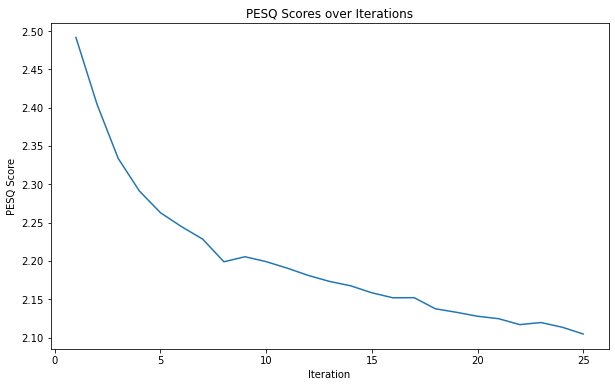

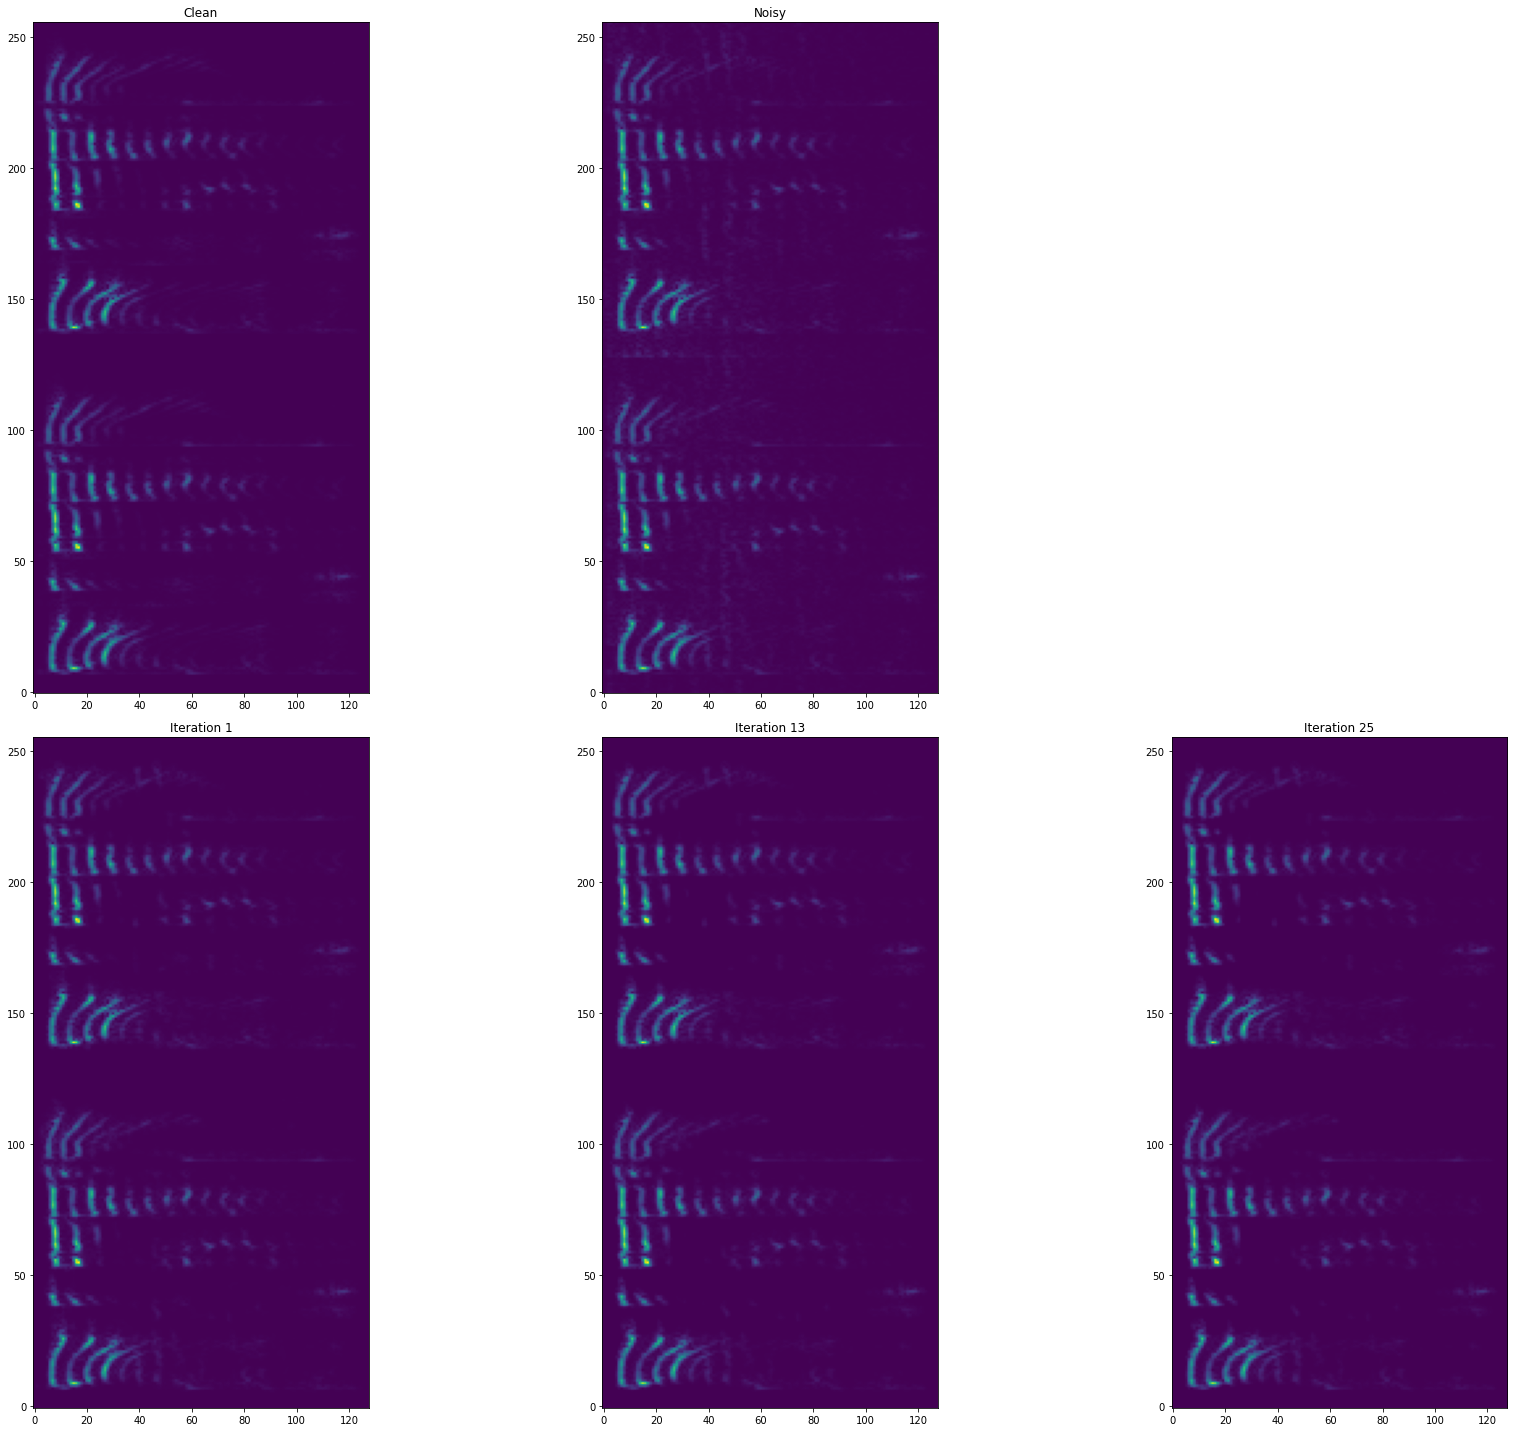

In [88]:
num_iterations = 25
def iterative_denoise(model, noisy_spec, num_iterations=5):
    assert isinstance(num_iterations, int) and 0 < num_iterations <= 100, "num_iterations should be a positive integer (max 100)."
    results = []
    current_spec = noisy_spec
    for _ in range(num_iterations):
        denoised_spec = model.predict(np.expand_dims(current_spec, 0))[0]
        results.append(denoised_spec)
        current_spec = denoised_spec
    return results

# Choose a sample to work with
sample_index = np.random.randint(0, len(spec_corrupt_array))
noisy_sample = spec_corrupt_array[sample_index]
clean_sample = wav_clean_array[sample_index]  # Use the clean waveform

# Perform iterative denoising
denoised_results = iterative_denoise(model, noisy_sample, num_iterations)

# Convert spectrograms back to audio
def spec_to_audio(spec):
    complex_spec = spec * np.exp(1j * np.angle(np.expand_dims(corr, 0)))
    return tf.signal.inverse_stft(complex_spec[0,:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step).numpy()

audio_results = [spec_to_audio(spec) for spec in denoised_results]

# Calculate PESQ for each iteration
pesq_scores = [pesq(clean_sample, denoised, sr) for denoised in audio_results]

# Plot PESQ scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pesq_scores) + 1), pesq_scores)
plt.title('PESQ Scores over Iterations')
plt.xlabel('Iteration')
plt.ylabel('PESQ Score')
plt.savefig(f'{results_dir}/iterative_pesq_scores.png')

# Plot spectrograms
plt.figure(figsize=(25, 20))
plt.subplot(2, 3, 1)
plt.imshow(spec_clean_array[sample_index], origin='lower')
plt.title('Clean')
plt.subplot(2, 3, 2)
plt.imshow(noisy_sample, origin='lower')
plt.title('Noisy')
counter = 3
for i in range(0, num_iterations, num_iterations // 2):
    counter += 1
    plt.subplot(2, 3, counter)
    plt.imshow(denoised_results[i], origin='lower')
    plt.title(f'Iteration {i+1}')
plt.tight_layout()
plt.savefig(f'{results_dir}/iterative_spectrograms.png')

# Calculate statistics
final_pesq_scores = np.array(pesq_scores)
print(f"Average PESQ: {np.mean(final_pesq_scores):.4f}")
print(f"Max PESQ: {np.max(final_pesq_scores):.4f}")
print(f"Min PESQ: {np.min(final_pesq_scores):.4f}")

# Display audio players
print("Clean Audio:")
display(Audio(clean_sample, rate=sr))

print("Noisy Audio:")
display(Audio(wav_corrupt_array[sample_index], rate=sr))

for i in range(0, num_iterations, num_iterations // 2):
    print(f"Denoised Audio (Iteration {i+1}):")
    display(Audio(audio_results[i], rate=sr))

# Save audio files
sf.write(f'{results_dir}/clean_audio.wav', clean_sample, sr)
sf.write(f'{results_dir}/noisy_audio.wav', wav_corrupt_array[sample_index], sr)
for i in range(0, num_iterations, num_iterations // 2):
    sf.write(f'{results_dir}/denoised_audio_iteration_{i+1}.wav', audio_results[i], sr)

In [89]:
test_ = np.expand_dims(corr_amp,0)

In [90]:
%%timeit -n 50
test = model.predict(test_)

35.5 ms ± 545 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [91]:
os.system(f'tar -cvzf train_{results_dir}.tar.gz {results_dir}')
print(f"All data has been saved under the output dir: {results_dir}")

val_results_16_16_4_30_0.07_0.2/
val_results_16_16_4_30_0.07_0.2/corrupt_worst_pesq_improvement.wav
val_results_16_16_4_30_0.07_0.2/clean_worst_pesq_improvement.wav
val_results_16_16_4_30_0.07_0.2/iterative_pesq_scores.png
val_results_16_16_4_30_0.07_0.2/correct_best_pesq_improvement.wav
val_results_16_16_4_30_0.07_0.2/correct_avg_pesq_improvement.wav
val_results_16_16_4_30_0.07_0.2/corrupt_best_pesq_improvement.wav
val_results_16_16_4_30_0.07_0.2/best_case_waveforms.png
val_results_16_16_4_30_0.07_0.2/BBC_first.wav_waveforms.png
val_results_16_16_4_30_0.07_0.2/snr_improvement_hist.png
val_results_16_16_4_30_0.07_0.2/denoised_audio_iteration_13.wav
val_results_16_16_4_30_0.07_0.2/BBC_second_cont.wav_waveforms.png
val_results_16_16_4_30_0.07_0.2/corrupt_avg_pesq_improvement.wav
val_results_16_16_4_30_0.07_0.2/clean_avg_pesq_improvement.wav
val_results_16_16_4_30_0.07_0.2/pesq_hist.png
val_results_16_16_4_30_0.07_0.2/noisy_audio.wav
val_results_16_16_4_30_0.07_0.2/clean_best_pesq_improve